In [7]:
import numpy as np
import matplotlib.pyplot as plt

from gpi import (
    make_geminisouth_aperture,
    make_gpi_apodizer,
    make_gpi_lyot
)

from hcipy import *
from poke.writing import read_serial_to_rayfront
from poke.interfaces import rayfront_to_hcipy_wavefront
import poke.plotting as plot

from prysm._richdata import Slices
import numpy as np

# Load up Gemini Rayfront

In [3]:
pth = 'gemini_south.msgpack'
rf = read_serial_to_rayfront(pth)
rf.wavelength = 1.6
rf.compute_jones_pupil()

97.57710405098302


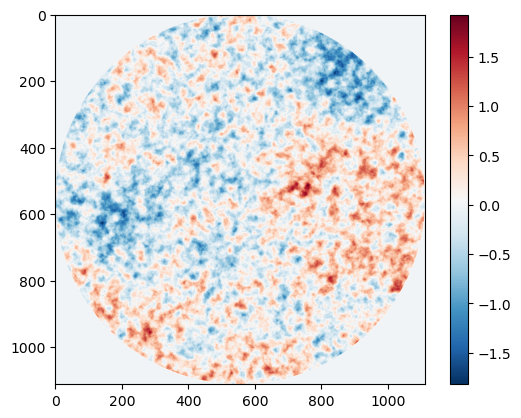

In [19]:
from astropy.io import fits
plt.style.use('default')
test = fits.getdata('sample_phs_screen.fits')
center = int(test.shape[0]/2)
cut = 556
plt.imshow(test[center-cut:center+cut,center-cut:center+cut,25], cmap='RdBu_r')
plt.colorbar()
print(np.std(test[center-cut:center+cut,center-cut:center+cut,-1]) / (2*np.pi) * 1600)

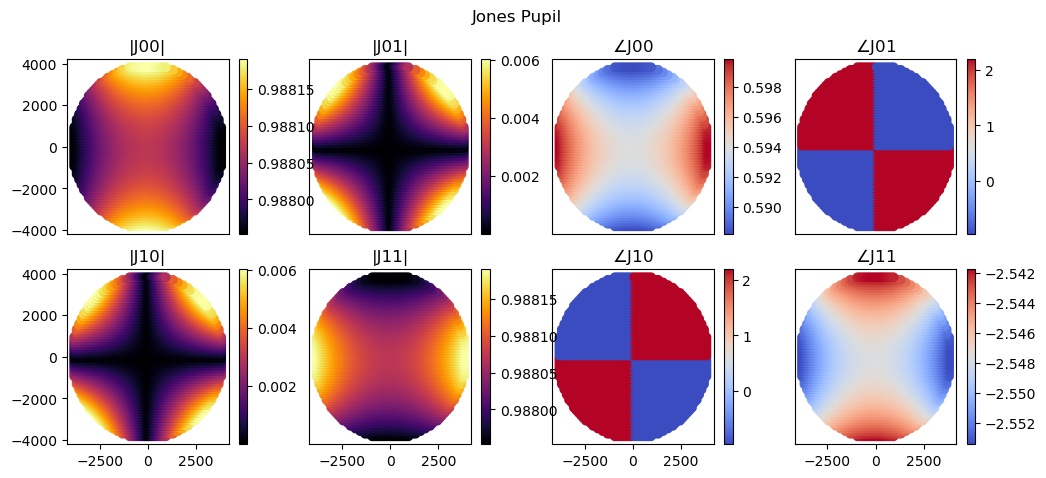

In [32]:

plot.jones_pupil(rf)

## Load up PAOLA Data

In [5]:
rf.surfaces

[{'surf': 3,
  'mode': 'reflect',
  'coating': [[array(1.98783284), array(0, dtype=int32)], (0.137+6.682j)]},
 {'surf': 4,
  'mode': 'reflect',
  'coating': [[array(1.98783284), array(0, dtype=int32)], (0.137+6.682j)]}]

# GPI Simulator

0.4995503597122302


/var/folders/83/ytrwsp9n3c3cly8tf8v6h03h0000gp/T/ipykernel_24900/3729240723.py:7: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  gpi_fpm = 1 - circular_aperture(5.65)(focal_grid)


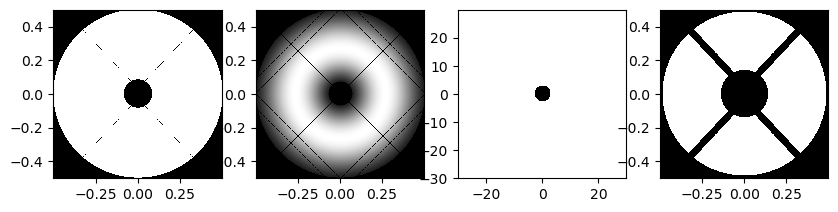

In [5]:
pupil_grid = make_pupil_grid(cut*2)
focal_grid = make_focal_grid(12,30)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

gemini_south_aperture = make_geminisouth_aperture(True)(pupil_grid)
gpi_apodizer = make_gpi_apodizer(True)(pupil_grid)
gpi_fpm = 1 - circular_aperture(5.65)(focal_grid)
gpi_lyot = make_gpi_lyot(True)(pupil_grid)

plt.figure(figsize=[10,3])
plt.subplot(141)
imshow_field(gemini_south_aperture, cmap='gray')
plt.subplot(142)
imshow_field(gpi_apodizer, cmap='gray')
plt.subplot(143)
imshow_field(gpi_fpm, cmap='gray')
plt.subplot(144)
imshow_field(gpi_lyot, cmap='gray')
plt.show()

# Convert Poke Rayfront to HCIPy Wavefront

In [7]:
wf = rayfront_to_hcipy_wavefront(rf, npix=cut*2, pupil_grid=pupil_grid)
wf_ref = Wavefront(gpi_apodizer)
to_lyot_ref = prop.backward(prop(wf_ref))
to_lyot_ref.electric_field *= gpi_lyot
power_norm = prop(to_lyot_ref).power.max()

In [26]:
# imshow_field(np.abs(wf.electric_field[1,1]) * gpi_apodizer)
# plt.colorbar()

## Simple PSF Simulation

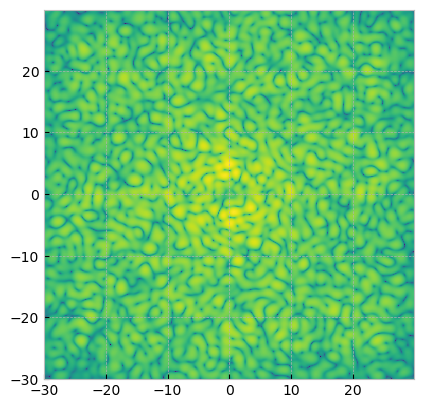

In [27]:
wfouts_h = []
wfouts_v = []
wfouts_p = []
wfouts_m = []
pbs_hv = LinearPolarizingBeamSplitter(0)
pbs_pm = LinearPolarizingBeamSplitter(np.pi / 4)

for i in range(100):

    frame = test[center-cut:center+cut,center-cut:center+cut,i]

    wf = rayfront_to_hcipy_wavefront(rf, npix=cut*2, pupil_grid=pupil_grid)
    phase_error = np.exp(1j*frame)
    wf.electric_field *= gemini_south_aperture * phase_error.ravel()
    wf.electric_field *= gpi_apodizer
    wf = prop(wf)
    norm = wf.intensity.max()
    wf.electric_field *= gpi_fpm
    wf = prop.backward(wf)
    wf.electric_field *= gpi_lyot
    wf = prop(wf)
    wfh, wfv = pbs_hv.forward(wf)
    wfp, wfm = pbs_pm.forward(wf)
    wfouts_h.append(wfh)
    wfouts_v.append(wfv)
    wfouts_p.append(wfp)
    wfouts_m.append(wfm)

imshow_field(np.log10(wf.I))

In [28]:
for i, (wfh, wfv, wfp, wfm) in enumerate(zip(wfouts_h, wfouts_v, wfouts_p, wfouts_m)):
    
    norm = np.sqrt(power_norm * 100)

    if i == 0: 
        
        wfh.electric_field /= norm
        wftotal_h = wfh.power

        wfv.electric_field /= norm
        wftotal_v = wfv.power

        wfp.electric_field /= norm
        wftotal_p = wfp.power

        wfm.electric_field /= norm
        wftotal_m = wfm.power

    else:

        wfh.electric_field /= norm
        wftotal_h += wfh.power

        wfv.electric_field /= norm
        wftotal_v += wfv.power

        wfp.electric_field /= norm
        wftotal_p += wfp.power

        wfm.electric_field /= norm
        wftotal_m += wfm.power

In [29]:
# which = 0
# np.save(f'100ms_exposure_0{which}_h.npy',wftotal_h)
# np.save(f'100ms_exposure_0{which}_v.npy',wftotal_v)
# np.save(f'100ms_exposure_0{which}_p.npy',wftotal_p)
# np.save(f'100ms_exposure_0{which}_m.npy',wftotal_m)

In [6]:
for i in range(0,10):
    if i == 0:
        wftotal_h = np.load(f'100ms_exposure_0{i}_h.npy')
        wftotal_v = np.load(f'100ms_exposure_0{i}_v.npy')
        wftotal_p = np.load(f'100ms_exposure_0{i}_p.npy')
        wftotal_m = np.load(f'100ms_exposure_0{i}_m.npy')
    else:
        wftotal_h += np.load(f'100ms_exposure_0{i}_h.npy')
        wftotal_v += np.load(f'100ms_exposure_0{i}_v.npy')
        wftotal_p += np.load(f'100ms_exposure_0{i}_p.npy')
        wftotal_m += np.load(f'100ms_exposure_0{i}_m.npy')

wftotal_h /= i+1
wftotal_v /= i+1
wftotal_p /= i+1
wftotal_m /= i+1

NameError: name 'wf' is not defined

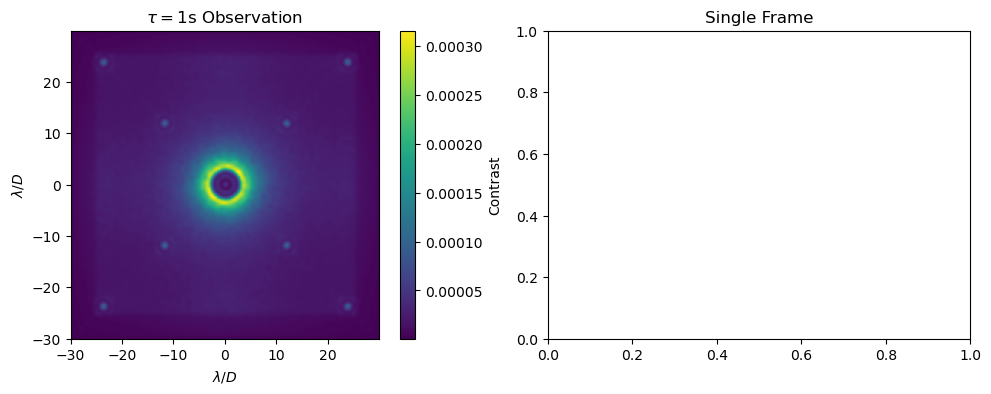

In [7]:
from matplotlib.colors import LogNorm

lognorm = LogNorm(vmin=1e-6, vmax=1e-3)

plt.figure(figsize=[12,4])
plt.subplot(121)
plt.title(r'$\tau=1$'+'s Observation')
imshow_field(wftotal_h, grid=focal_grid)
plt.xlabel(r'$\lambda / D$')
plt.ylabel(r'$\lambda / D$')
plt.colorbar(label='Contrast')
plt.subplot(122)
plt.title('Single Frame')
imshow_field((wf.I), norm=lognorm)
plt.colorbar()
plt.show()

Q near IWA =  -4.1441411149254215e-08
U near IWA =  -1.3401134884094179e-08


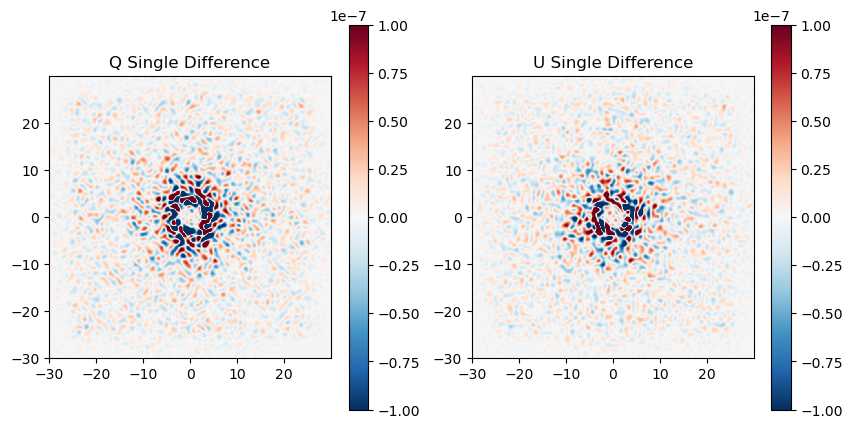

In [14]:
vlim = 1e-7
u = np.linspace(-30,30,720)
u, v = np.meshgrid(u, u)
rho = np.sqrt(u**2 + v**2)
rho = rho.ravel()
focal_mask = np.zeros_like(wftotal_h)
focal_mask[rho > 3] = 1
focal_mask[rho > 4] = 0
q = wftotal_h - wftotal_v
u = wftotal_p - wftotal_m
print('Q near IWA = ', np.mean(q[focal_mask==1]))
print('U near IWA = ', np.mean(u[focal_mask==1]))
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.title('Q Single Difference')
imshow_field(q, grid=focal_grid, cmap='RdBu_r', vmin=-vlim, vmax=vlim)
plt.colorbar()
plt.subplot(122)
plt.title('U Single Difference')
imshow_field(u, grid=focal_grid, cmap='RdBu_r', vmin=-vlim, vmax=vlim)
plt.colorbar()
plt.show()

In [58]:
x = np.linspace(-30,30,wftotal_h.reshape([720,720]).shape[0])
y = np.copy(x)

I = Slices(wftotal_h.reshape([720,720]) + wftotal_v.reshape([720,720]), x, y)
std_i = I.azstd

Q = Slices(wftotal_h.reshape([720,720]) - wftotal_v.reshape([720,720]), x, y)
std_q = Q.azstd
U = Slices(wftotal_p.reshape([720,720]) - wftotal_m.reshape([720,720]), x, y)
std_u = U.azstd

In [4]:
# np.save('std_I_1s_1mmtint.npy',std_i[1])
# np.save('std_Q_1s_1mmtint.npy',std_q[1])
# np.save('std_U_1s_1mmtint.npy',std_u[1])
x = np.linspace(0,30,std_i_1s.shape[0])
std_u = [x]

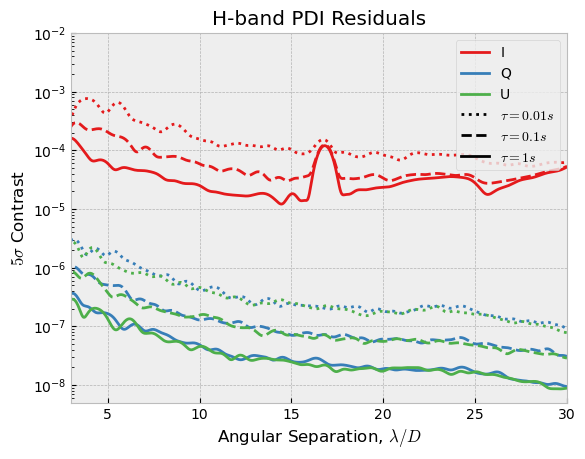

In [6]:
std_i_1s = np.load('std_I_1s_1mmtint.npy')
std_q_1s = np.load('std_Q_1s_1mmtint.npy')
std_u_1s = np.load('std_U_1s_1mmtint.npy')

std_i_01s = np.load('std_I_0.1s_1mmtint.npy')
std_q_01s = np.load('std_Q_0.1s_1mmtint.npy')
std_u_01s = np.load('std_U_0.1s_1mmtint.npy')

std_i_001s = np.load('std_I_0.01s_1mmtint.npy')
std_q_001s = np.load('std_Q_0.01s_1mmtint.npy')
std_u_001s = np.load('std_U_0.01s_1mmtint.npy')

plt.style.use('bmh')
n = 9
color = plt.cm.Set1(np.linspace(0,1,n))
xpro = std_u[0]#np.linspace(0,30,len(std_i_01s))

plt.title('H-band PDI Residuals')
plt.plot(xpro,std_i_1s * 5, label='I', color=color[0], linestyle='solid')
plt.plot(xpro,std_q_1s * 5, label='Q', color=color[1], linestyle='solid')
plt.plot(xpro,std_u_1s * 5, label='U', color=color[2], linestyle='solid')
plt.plot(xpro,std_i_01s * 5, color=color[0], linestyle='dashed')
plt.plot(xpro,std_q_01s * 5, color=color[1], linestyle='dashed')
plt.plot(xpro,std_u_01s * 5, color=color[2], linestyle='dashed')
plt.plot(xpro,std_i_001s * 5, color=color[0], linestyle='dotted')
plt.plot(xpro,std_q_001s * 5, color=color[1], linestyle='dotted')
plt.plot(xpro,std_u_001s * 5, color=color[2], linestyle='dotted')
plt.plot(xpro,np.zeros_like(std_i_01s), color='k', linestyle='dotted', label=r'$\tau=0.01s$')
plt.plot(xpro,np.zeros_like(std_i_01s), color='k', linestyle='dashed', label=r'$\tau=0.1s$')
plt.plot(xpro,np.zeros_like(std_i_01s), color='k', linestyle='solid', label=r'$\tau=1s$')
plt.yscale('log')
plt.ylim(5e-9,1e-2)
plt.xlim(3,30)
plt.ylabel(r'$5\sigma$'+' Contrast')
plt.xlabel('Angular Separation, '+r'$\lambda / D$')
plt.legend()

In [43]:
0.25 / 206265 * (8.1 / 1.65e-6)

5.9499804972861465